## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
%pip install nlp
%pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
from datasets import load_dataset
dataset = load_dataset('emotion')

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

e:\Python\first-ml-project\first_attempt\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pc\.cache\huggingface\hub\datasets--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = dataset['train']
val =  dataset['validation']
test = dataset['test']

In [8]:
def get_tweets(dataset):
    tweets = [x['text'] for x in dataset]
    labels = [x['label'] for x in dataset]
    return tweets, labels


In [9]:
tweets, labels = get_tweets(train)

In [10]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [13]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [14]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

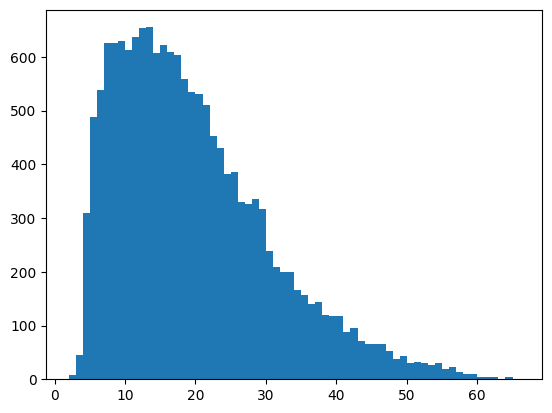

In [15]:
lenghts = [len(t.split(' ')) for t in tweets]
plt.hist(lenghts, bins=len(set(lenghts)))
plt.show()

### We can remarque that most of our tweets have lenght of 10 to 30 words


In [16]:
max_lenght  = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [17]:
def get_sequences(tokenize , tweets):
    sequences = tokenize.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, maxlen=max_lenght, padding='post', truncating='post')
    return padded_sequences

In [18]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [19]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [20]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


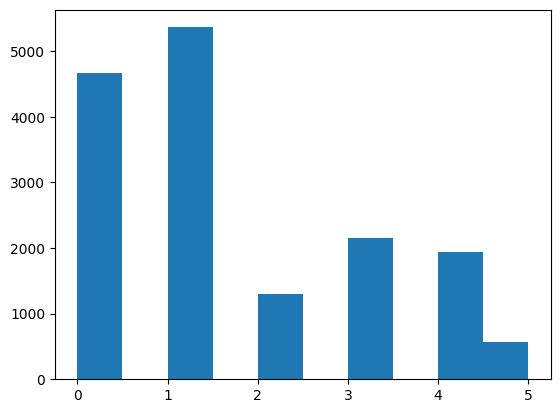

In [21]:
plt.hist(labels)
plt.show()

The dataset i used is already labeled no need to Converting text labels to numeric labels, cause they are already assigned a numeric value


In [22]:
class_to_index= dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [23]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [24]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [25]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [26]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

e:\Python\first-ml-project\first_attempt\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
dummy_input = np.zeros((1, 50))  # 1 sample, sequence length = 50
model(dummy_input)

# Now you can call model.summary()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 50, 16)            │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 50, 40)            │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (1, 20)                │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 6)                 │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,126 (664.55 KB)

 Trainable params: 170,126 (664.55 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [30]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets)
labels = np.array(labels)
val_labels = np.array(val_labels)


In [31]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [32]:
h = model.fit(
    padded_train_sequences,train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3821 - loss: 1.5484 - val_accuracy: 0.5860 - val_loss: 1.1298
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.6113 - loss: 1.0038 - val_accuracy: 0.7190 - val_loss: 0.7993
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7696 - loss: 0.6325 - val_accuracy: 0.7785 - val_loss: 0.6509
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8739 - loss: 0.3936 - val_accuracy: 0.8270 - val_loss: 0.5378
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9107 - loss: 0.2735 - val_accuracy: 0.8480 - val_loss: 0.4895
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9393 - loss: 0.2073 - val_accuracy: 0.8605 - val_loss: 0.4672
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.9578 - loss: 0.1442 - val_accuracy: 0.8695 - val_loss: 0.4338
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9657 - loss: 0.1122 - v

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

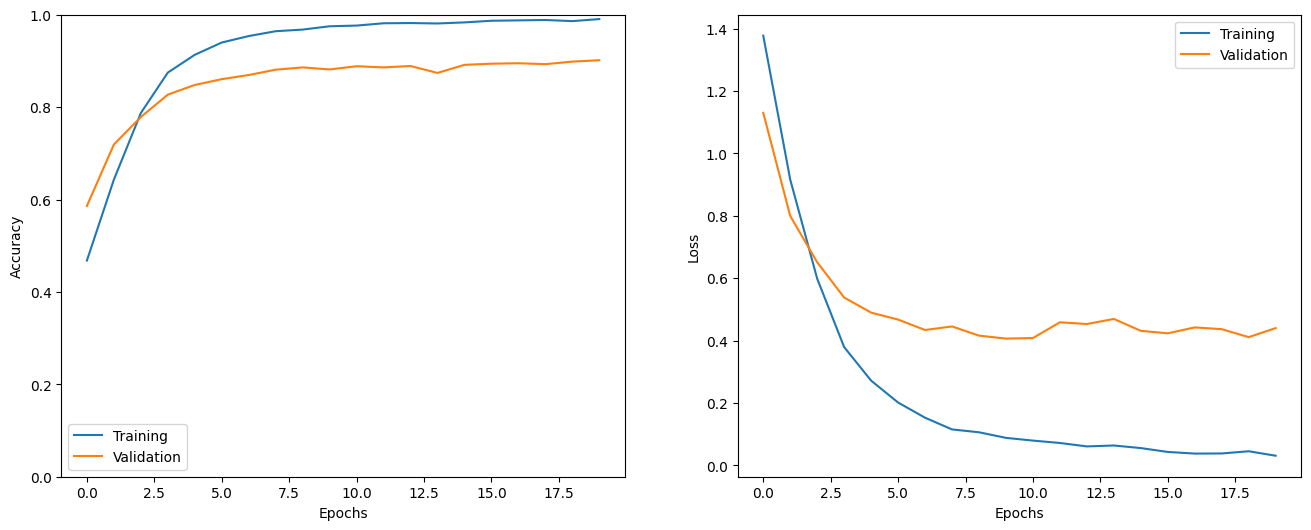

In [33]:
show_history(h)

In [34]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [35]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8924 - loss: 0.4440


In [36]:
i = random.randint(0, len(test_labels)-1)
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

prediction = model.predict(np.expand_dims(test_seq[i], axis=0))  # shape: (1, 6)
pred_class = index_to_class[np.argmax(prediction)]

print('Predicted Emotion:', pred_class)

Sentence: i told my fiance how i am feeling so angry and upset
Emotion: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
Predicted Emotion: 3


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


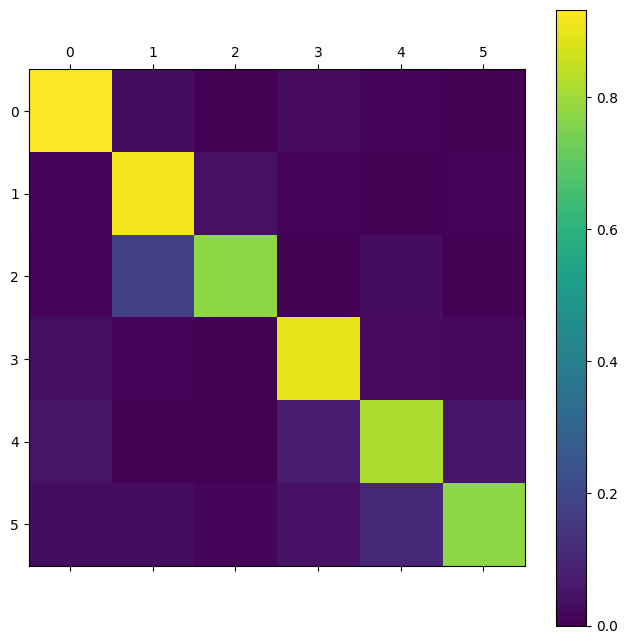

In [37]:
preds = model.predict(test_seq)
preds = np.argmax(preds, axis=1)
show_confusion_matrix(test_labels, preds, list(classes))

we can see that in our confusion matrix that all the prediction are generally correct, that is because classe imbalance , so if we can correct that and more data in the other classes we can have better results
